In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit, minimize
import pandas as pd
from scipy.signal import find_peaks
from matplotlib.gridspec import GridSpec
from matplotlib import cm
import matplotlib as mpl
from scipy.integrate import odeint
from scipy.interpolate import CubicSpline
import scipy

import time
from tqdm import tqdm, trange

Lyapunov exponents

In [9]:
def norm(x, y):
    return np.max(abs(x-y),axis=1)

In [11]:
def Lyapunov(t, x, K=25, d_E=22, d_M=6, rM=0.05, rm=0.01):
    N=len(x)
    tau=t[1]-t[0]
    
    # matrix dimension
    m=int((d_E-1)/(d_M-1))

    # r: radius of the 'ball'
    rM=0.05; rm=0.01

    # reconstruct x by time delay
    x_re=np.zeros((N-2*d_E+1, d_M))
    for i in range(N-2*d_E): x_re[i]=x[i:i+d_E:m]

    # find neighbors for each i and least square
    Q=np.identity(d_M); DIAG=np.zeros(d_M)
    
    #Build k-d tree
    kdtree = cKDTree(x_re)
    
    for i in range(K):
        i0=1+i*m
        inner_member = set(kdtree.query_ball_point(x_re[i0],rm))
        outer_member = set(kdtree.query_ball_point(x_re[i0],rM))
        SE_r = outer_member-inner_member #with in rm<r<rM
        n_temp=len(SE_r); init_temp=1/d_M*np.ones(d_M)
        def LS(a):
            temp=0
            for j in SE_r:
                ttemp=0
                for k in range(d_M):
                    ttemp += a[k]*(x_re[j][k]-x_re[i0][k])  # -(x_re[j][:-1]-x_re[i][:-1]))
                temp+=(ttemp-(x[j+d_M*m]-x[i0+d_M*m]))**2
            return temp
        T=np.zeros((d_M, d_M))
        for i in range(d_M-1): T[i][i+1]=1
        result=minimize(LS, init_temp, method='Powell')
        T[-1, :]=result.x
        #print(T)
        #T[d_M-1]=minimize(LS, init_temp, method='Powell').x
        Q, R=np.linalg.qr(T@Q)
        
        # Ensure all diagonal elements of R are positive
        signs = np.sign(np.diag(R))
        Q *= signs
        R *= signs

        #print(R)
        DIAG+=np.diag(scipy.linalg.logm(R))

    return DIAG/(tau*K*m)

In [ ]:
lyaps=[]
cutoff=int(len(t_tot[0])*0.9)
for i in tqdm(range(len(freqs))):
    lyaps.append((Lyapunov(t_tot[freqs[i]-100][cutoff:], V1_tot[freqs[i]-100][cutoff:])))#, K=25, d_E=22, d_M=6, rM=0.05, rm=0.01)))

 17%|████████████▊                                                               | 1667/9901 [11:08<2:34:01,  1.12s/it]

logm result may be inaccurate, approximate err = 2.2629186013603451e-13


 27%|████████████████████▋                                                       | 2698/9901 [15:55<1:34:32,  1.27it/s]

logm result may be inaccurate, approximate err = 6.484850092494254e-12


 33%|█████████████████████████                                                   | 3273/9901 [19:50<2:03:18,  1.12s/it]

logm result may be inaccurate, approximate err = 3.3809399467082485e-13


 41%|████████████████████████████████▎                                             | 4100/9901 [26:34<48:19,  2.00it/s]

logm result may be inaccurate, approximate err = 3.1230852148216975e-13


 62%|█████████████████████████████████████████████▋                            | 6113/9901 [1:00:49<1:34:07,  1.49s/it]C:\Users\jiwon\anaconda3\envs\main\lib\site-packages\scipy\linalg\_matfuncs_inv_ssq.py:827: LogmExactlySingularWarning: The logm input matrix is exactly singular.
  warnings.warn(exact_singularity_msg, LogmExactlySingularWarning)
 78%|█████████████████████████████████████████████████████████▉                | 7751/9901 [1:58:40<1:10:22,  1.96s/it]

logm result may be inaccurate, approximate err = 3.5784425401693996e-13


 83%|███████████████████████████████████████████████████████████████▍            | 8261/9901 [2:15:14<58:10,  2.13s/it]

In [117]:
max_lyaps=np.max(lyaps, axis=1)-5000
Pos_lyap=np.where(max_lyaps>0)[0]
Neg_lyap=np.where(max_lyaps<=0)[0]

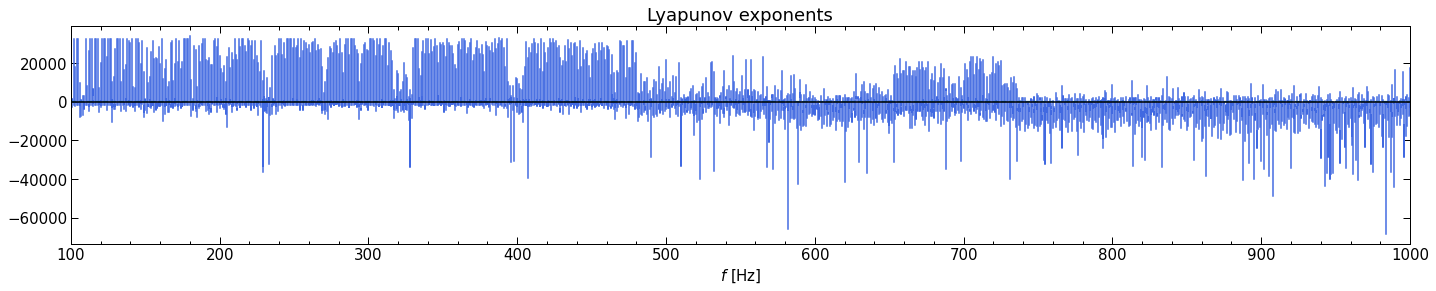

In [116]:
plt.figure(figsize=(24, 4))
for i in range(len(freqspan)):
    plt.plot(freqspan[i]*np.ones(len(lyaps[i])), lyaps[i], markersize=2, color='royalblue')
plt.plot(freqspan, max_lyaps, ls='dashed')
plt.axhline(0, color='black')
plt.title('Lyapunov exponents')
plt.xlabel('$f$ [Hz]')
plt.xlim(100, 1000)
#plt.ylim(5000,)
plt.show()